<a href="https://colab.research.google.com/github/Rinshavip/ISL_CNN_MODEL/blob/main/ISL_cnn_batch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow opencv-python matplotlib

In [ ]:
import tensorflow as tf
import os
import numpy as np
from matplotlib import pyplot as plt
from google.colab import drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
#Define the path to your dataset

log_dir = '/content/drive/MyDrive/m2project/ISL-dataset-BG/logs'
my_drive_path = '/content/drive/MyDrive/m2project/ISL-dataset-BG'
save_directory = '/content/drive/MyDrive/m2project/ISL-dataset-BG/saved'


In [ ]:
# Load dataset with proper shuffling and validation splitts
ts=tf.keras.utils.image_dataset_from_directory(
    my_drive_path,
    image_size=(48, 48),
    batch_size=32,
    color_mode='grayscale',
    shuffle=True,  # Ensure dataset is shuffled
    seed=42
)


Found 7020 files belonging to 36 classes.


In [ ]:
# Normalize pixel values
scaled_ts = ts.map(lambda x, y: (x/255, y))


In [ ]:
# Correct dataset splitting using TF's built-in functionality
train_size = int(0.7 * len(ts))
val_size = int(0.2 * len(ts))
test_size = len(ts) - train_size - val_size  # Handles remainder
train = scaled_ts.take(train_size)
remaining = scaled_ts.skip(train_size)
val = remaining.take(val_size)
test = remaining.skip(val_size)

In [ ]:
# Model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48,1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(35, activation='softmax')
])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 46, 46, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 21, 21, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 35)             │         8,995 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 627,107 (2.39 MB)

 Trainable params: 626,659 (2.39 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
# Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

In [ ]:
# Enhanced training pipeline with shuffling
augmented_train = train.map(lambda x, y: (data_augmentation(x, training=True), y))
augmented_train = augmented_train.shuffle(buffer_size=1024)#add shuffling

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                               factor=0.7,
                                               patience=2,
                                               min_lr=0.000000)

In [ ]:
# Train model
history = model.fit(
    augmented_train,
    epochs=20,
    validation_data=val,
    callbacks=[tensorboard_callback, reduce_lr]
)

Epoch 1/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 337s 2s/step - accuracy: 0.4477 - loss: 2.3385 - val_accuracy: 0.0327 - val_loss: 7.8539 - learning_rate: 5.0000e-04
Epoch 2/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 83s 439ms/step - accuracy: 0.8727 - loss: 0.5149 - val_accuracy: 0.0526 - val_loss: 7.0631 - learning_rate: 5.0000e-04
Epoch 3/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 85s 450ms/step - accuracy: 0.8995 - loss: 0.3971 - val_accuracy: 0.6101 - val_loss: 1.1903 - learning_rate: 5.0000e-04
Epoch 4/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 68s 338ms/step - accuracy: 0.8975 - loss: 0.3845 - val_accuracy: 0.8913 - val_loss: 0.3817 - learning_rate: 5.0000e-04
Epoch 5/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 85s 452ms/step - accuracy: 0.9041 - loss: 0.3546 - val_accuracy: 0.8963 - val_loss: 0.3778 - learning_rate: 5.0000e-04
Epoch 6/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 88s 471ms/step - accuracy: 0.9118 - loss: 0.3352 - val_accuracy: 0.8999 - val_loss: 0.3609 - learning_rate: 5.0000e-04
Epoch 7/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 85s 451m

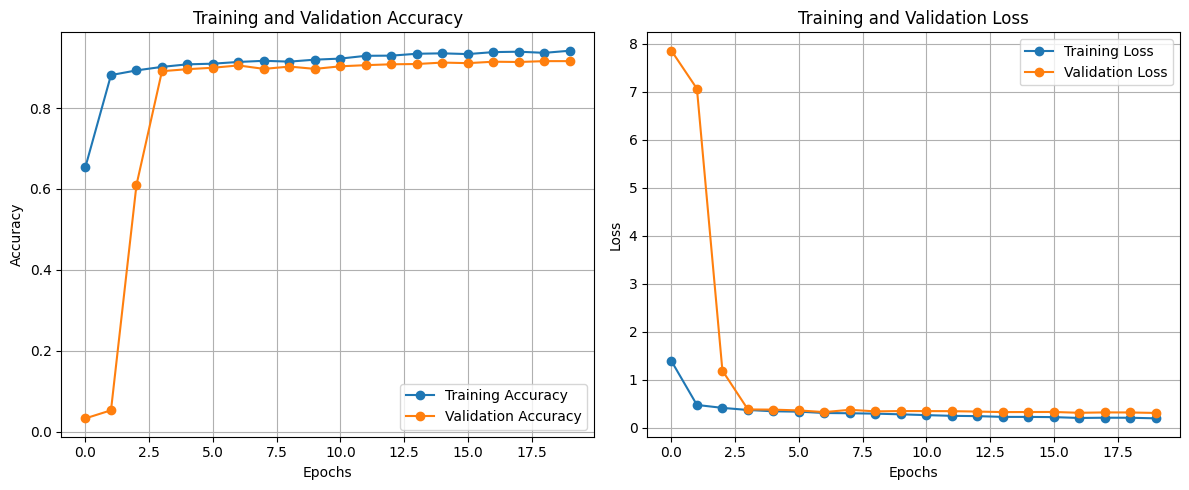

In [ ]:
import matplotlib.pyplot as plt

# Retrieve training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs_range = range(len(acc))

# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(test)
# Optionally print values
print(f"\nTest Accuracy: {test_acc * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")



22/22 ━━━━━━━━━━━━━━━━━━━━ 105s 4s/step - accuracy: 0.9035 - loss: 0.3805

Test Accuracy: 90.94%
Test Loss: 0.3441


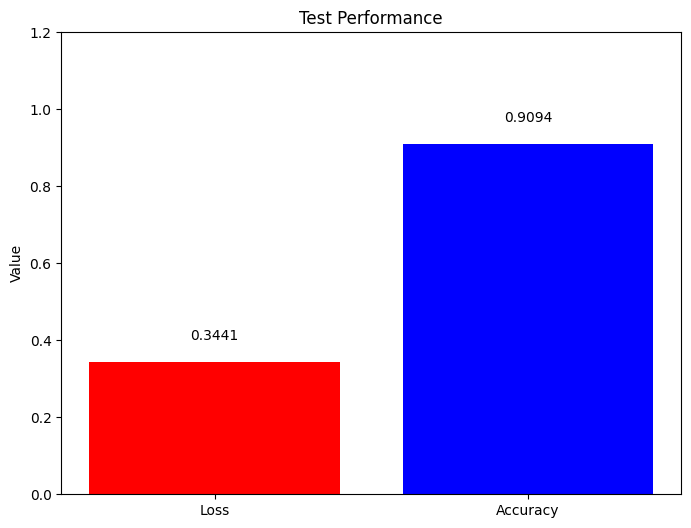

In [ ]:
import matplotlib.pyplot as plt

   # Test data (single points)
test_metrics = [test_loss, test_acc]
metric_labels = ['Loss', 'Accuracy']

   # Bar plot for visualization
plt.figure(figsize=(8, 6))
plt.bar(metric_labels, test_metrics, color=['red', 'blue'])
plt.title('Test Performance')
plt.ylabel('Value')
plt.ylim([0, 1.2])  # Adjust y-axis limits if necessary
# Display values on top of bars
for i, v in enumerate(test_metrics):
    plt.text(i, v + 0.05, f'{v:.4f}', ha='center', va='bottom')

plt.show()

In [ ]:
# Save model
model.save(f'{save_directory}/ISL_CNN_model.h5')
print(f"Model saved successfully to: {save_directory}/ISL_CNN_model.h5")

Model saved successfully to: /content/drive/MyDrive/m2project/ISL-dataset-BG/saved/ISL_CNN_model.h5
